# فاز 1

## بارگذاری داده ها

In [2]:
!pip install kagglehub[pandas-datasets]


In [3]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd


# Set the path to the file you'd like to load
file_path = "ecommerceDataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "saurabhshahane/ecommerce-text-classification",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipython-input-3-3445686076.py:12: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:    Household  \
0  Household   
1  Household   
2  Household   
3  Household   
4  Household   

  Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour a

In [4]:
import pandas as pd

# مسیر فایل
file_path = "/kaggle/input/ecommerce-text-classification/ecommerceDataset.csv"

# بارگذاری داده‌ها با تعیین نام ستون‌ها
df = pd.read_csv(file_path, header=None, names=["category", "text"])
#کم کردن حجم داده ها
df = df.sample(n=5000, random_state=42)
# نمایش ۵ نمونه اول
df.head()


,category,text
35848,Clothing & Accessories,Kandy Men's Regular Fit Blazer Blue This produ...
13005,Household,HealthSense Chef-Mate KS 50 Digital Kitchen Sc...
22719,Books,Concept of Physics (2018-2019) Session (Set of...
18453,Household,Lista Stainless Steel Multi Functional Hammer ...
20867,Books,Gardening in Urban India update


In [5]:
df.columns = ["category", "text"]
df.head()

,category,text
35848,Clothing & Accessories,Kandy Men's Regular Fit Blazer Blue This produ...
13005,Household,HealthSense Chef-Mate KS 50 Digital Kitchen Sc...
22719,Books,Concept of Physics (2018-2019) Session (Set of...
18453,Household,Lista Stainless Steel Multi Functional Hammer ...
20867,Books,Gardening in Urban India update


## تابع پیش‌پردازش متن

In [6]:
import re
import string
import nltk

nltk.download("stopwords")   # کلمات توقف (Stopwords)
nltk.download("punkt")       # برای توکن‌سازی متن
nltk.download("wordnet")     # برای Lemmatization

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
def preprocess(text):
    # اطمینان از اینکه ورودی رشته است
    if not isinstance(text, str):
        return ""

    stop_words = set(stopwords.words("english"))  # ساختن مجموعه کلمات توقف
    lemmatizer = WordNetLemmatizer()              # ایجاد آبجکت برای مثلا تبدیل فعل ها به ریشه

    # lowercase
    text = text.lower()

    # حذف URLها
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # حذف ایمیل‌ها
    text = re.sub(r'\S+@\S+', '', text)

    # حذف اعداد تنها یا ترکیب‌شده
    text = re.sub(r'\b\d+\b', '', text)

    # حذف HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # حذف punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)

    # حذف کاراکترهای تکراری کش‌دار (مثلاً soooo → so)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # حذف فضای اضافه بین کلمات
    text = re.sub(r'\s+', ' ', text).strip()

    # split (توکن‌سازی ساده)
    tokens = text.split()

    # حذف stopwords و Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]

    return ' '.join(tokens)



In [8]:
# اعمال پیش‌پردازش
df["clean_text"] = df["text"].apply(preprocess)

# نمایش نمونه‌ها
df[["text", "clean_text"]].head()


,text,clean_text
35848,Kandy Men's Regular Fit Blazer Blue This produ...,kandy men regular fit blazer blue product made...
13005,HealthSense Chef-Mate KS 50 Digital Kitchen Sc...,healthsense chefmate digital kitchen scale grey
22719,Concept of Physics (2018-2019) Session (Set of...,concept physic session set volume
18453,Lista Stainless Steel Multi Functional Hammer ...,lista stainless steel multi functional hammer ...
20867,Gardening in Urban India update,gardening urban india update


# فاز 2

##TF-IDF

In [9]:
import numpy as np
from collections import Counter, defaultdict
import math

# متون تمیز شده
documents = df["clean_text"].tolist()
N = len(documents)  # تعداد کل اسناد

# 1. محاسبه DF برای هر واژه
df_counts = defaultdict(int)  # document frequency

for doc in documents:
    unique_words = set(doc.split())
    for word in unique_words:
        df_counts[word] += 1

# 2. محاسبه IDF برای هر واژه
idf = {}
for word, df_count in df_counts.items():
    idf[word] = math.log(N / (1 + df_count))  # افزودن 1 برای جلوگیری از تقسیم بر صفر


In [10]:
# تمام کلمات موجود (واژگان نهایی)
vocab = sorted(idf.keys())
word2idx = {word: idx for idx, word in enumerate(vocab)}

# ایجاد ماتریس ویژگی N × V
tfidf_matrix = np.zeros((N, len(vocab)))

for i, doc in enumerate(documents):
    word_counts = Counter(doc.split())
    total_words = sum(word_counts.values())

    for word, count in word_counts.items():
        if word in idf:
            tf = count / total_words
            tfidf_matrix[i, word2idx[word]] = tf * idf[word]


In [ ]:
#print the first one
print(documents[0])  # سند پیش‌پردازش شده
for word in documents[0].split():
    if word in idf:
        print(word, "→ tf-idf:", idf[word])
    else:
        print(word, "❌ not in vocab")



saf floral framed painting wood inch inch special effect print textured sao297 painting made synthetic frame textured print give multi effect attracts towards special series painting make wall beautiful give royal touch perfect gift special one
saf → tf-idf: 7.244703592736836
floral → tf-idf: 4.68618512560559
framed → tf-idf: 6.608714826016839
painting → tf-idf: 5.137863076868886
wood → tf-idf: 3.576877547820732
inch → tf-idf: 2.4161676579000133
inch → tf-idf: 2.4161676579000133
special → tf-idf: 3.352316561825549
effect → tf-idf: 3.9214677525443924
print → tf-idf: 3.35799839529298
textured → tf-idf: 5.519954833791742
sao297 → tf-idf: 9.729610242524837
painting → tf-idf: 5.137863076868886
made → tf-idf: 1.7561102785002065
synthetic → tf-idf: 5.452944123508781
frame → tf-idf: 3.851874460745197
textured → tf-idf: 5.519954833791742
print → tf-idf: 3.35799839529298
give → tf-idf: 2.367599691265103
multi → tf-idf: 3.983407051984683
effect → tf-idf: 3.9214677525443924
attracts → tf-idf: 7.11

## word2vec

In [11]:
!pip install gensim

In [12]:
#وارد کردن کتابخانه‌ها و آماده‌سازی داده‌ها


import nltk
nltk.download('punkt_tab')  # یا nltk.download('punkt')

from nltk.tokenize import word_tokenize

sentences = df["clean_text"].apply(word_tokenize).tolist()



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [13]:
# آموزش مدل Word2Vec
# vector_size: اندازه بردار خروجی هر کلمه (مثلاً 100)
# window: تعداد کلماتی که قبل و بعد کلمه را در نظر می‌گیرد (مثلاً 5)
# min_count: حداقل تعداد تکرار یک کلمه برای وارد شدن به مدل (مثلاً 2)
# workers: تعداد هسته‌های پردازشی

#mobina
from gensim.models import Word2Vec

model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)


In [ ]:
# بردار عددی کلمه "painting"
vector = model.wv['painting']
print(f"Vector for 'painting':\n{vector}\n")

# تشخیص شباهت بین دو کلمه
similarity = model.wv.similarity('painting', 'art')
print(f"Similarity between 'painting' and 'art': {similarity}")

# یافتن کلمات نزدیک به "painting"
similar_words = model.wv.most_similar('painting', topn=5)
print("Most similar words to 'painting':")
for word, score in similar_words:
    print(f"{word}: {score}")


Vector for 'painting':
[-0.5508629   0.36387342 -0.36982006 -1.056777   -0.22129601 -0.11388729
 -1.4613373  -0.73587257 -1.2004316   2.6038702   0.2659391  -0.6010603
  1.0231673  -0.92522097 -0.79301536 -1.2032902   1.4779582   2.5695066
 -0.15849325  1.3117727  -0.2737219  -0.61334205 -0.5723068   0.25922787
  0.81314796  0.60878175 -0.35792628 -0.6534402   0.7085712  -1.3418529
 -0.53413486 -0.42737135  0.68361074 -0.19693144 -0.2622345  -0.19879907
 -2.0610995  -0.6067788  -0.26163772 -0.28893083  0.2548341  -1.48044
 -2.6918893   0.86935455 -1.7898625   0.23239349 -1.2008233  -1.0039829
  1.537418   -1.3866178  -1.1436353  -0.8453917  -1.0944076   0.17852592
  0.9740102   0.05182031 -0.6212762  -1.4812379  -1.5863237  -0.35590577
  0.42921606 -1.2403116   0.48564795 -1.1095368   0.5501702  -1.0542358
 -0.35811844  1.2013218  -1.0504943   1.2214376  -0.88091445  0.7849959
  0.2985102  -0.42124787  0.01212086 -0.2500986   0.52507186 -0.41478604
  0.80750847  1.1138465  -0.0455182  

# فاز 3 و 4


In [14]:
import numpy as np

# ذخیره به صورت فایل .npy
np.save("tfidf_matrix.npy", tfidf_matrix)

# ذخیره واژگان برای نگه‌داشتن mapping
import pickle
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)


In [ ]:
import numpy as np

# بارگذاری ماتریس TF-IDF
tfidf_matrix = np.load("tfidf_matrix.npy")
import pickle

# بارگذاری دیکشنری واژگان
with open("word2idx.pkl", "rb") as f:
    word2idx = pickle.load(f)


## tf-idf


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

X = tfidf_matrix  # ← داده‌های بردارسازی‌شده با TF-IDF
y = df["category"]  # ← برچسب دسته‌بندی

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Linear SVC": LinearSVC(),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"🧪 {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred), "\n")



🧪 Logistic Regression
Accuracy: 0.94
                        precision    recall  f1-score   support

                 Books       0.97      0.91      0.94       237
Clothing & Accessories       0.98      0.94      0.96       189
           Electronics       0.93      0.91      0.92       202
             Household       0.91      0.97      0.94       372

              accuracy                           0.94      1000
             macro avg       0.95      0.93      0.94      1000
          weighted avg       0.94      0.94      0.94      1000
 

🧪 Random Forest
Accuracy: 0.911
                        precision    recall  f1-score   support

                 Books       0.90      0.92      0.91       237
Clothing & Accessories       0.95      0.93      0.94       189
           Electronics       0.93      0.85      0.89       202
             Household       0.89      0.93      0.91       372

              accuracy                           0.91      1000
             macro avg      

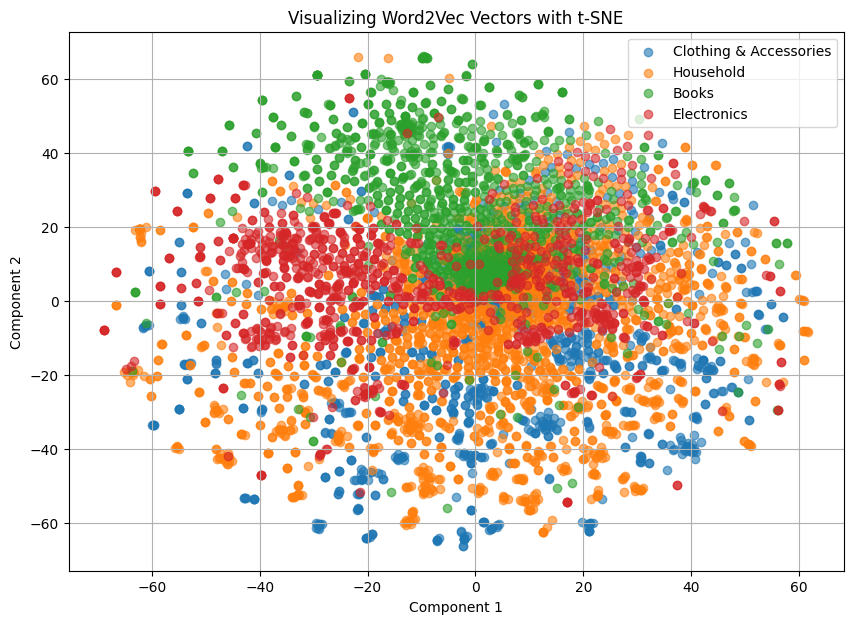

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


X_vis = tfidf_matrix

# کاهش ابعاد با t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_vis)

# رسم
plt.figure(figsize=(10, 7))
for label in df["category"].unique():
    indices = df["category"] == label
    plt.scatter(X_2d[indices, 0], X_2d[indices, 1], label=label, alpha=0.6)

plt.legend()
plt.title("Visualizing tfidf Vectors with t-SNE")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

## word2vec


In [15]:
def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv]
    return np.mean([model.wv[word] for word in doc], axis=0) if doc else np.zeros(model.vector_size)

X_w2v = np.array([document_vector(doc, model) for doc in sentences])


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

X = X_w2v
y = df["category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Linear SVC": LinearSVC(),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"🧪 {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred), "\n")



🧪 Logistic Regression
Accuracy: 0.905
                        precision    recall  f1-score   support

                 Books       0.95      0.90      0.92       237
Clothing & Accessories       0.92      0.92      0.92       189
           Electronics       0.88      0.87      0.87       202
             Household       0.89      0.92      0.90       372

              accuracy                           0.91      1000
             macro avg       0.91      0.90      0.90      1000
          weighted avg       0.91      0.91      0.91      1000
 

🧪 Random Forest
Accuracy: 0.914
                        precision    recall  f1-score   support

                 Books       0.96      0.91      0.93       237
Clothing & Accessories       0.94      0.92      0.93       189
           Electronics       0.88      0.91      0.90       202
             Household       0.90      0.92      0.91       372

              accuracy                           0.91      1000
             macro avg     

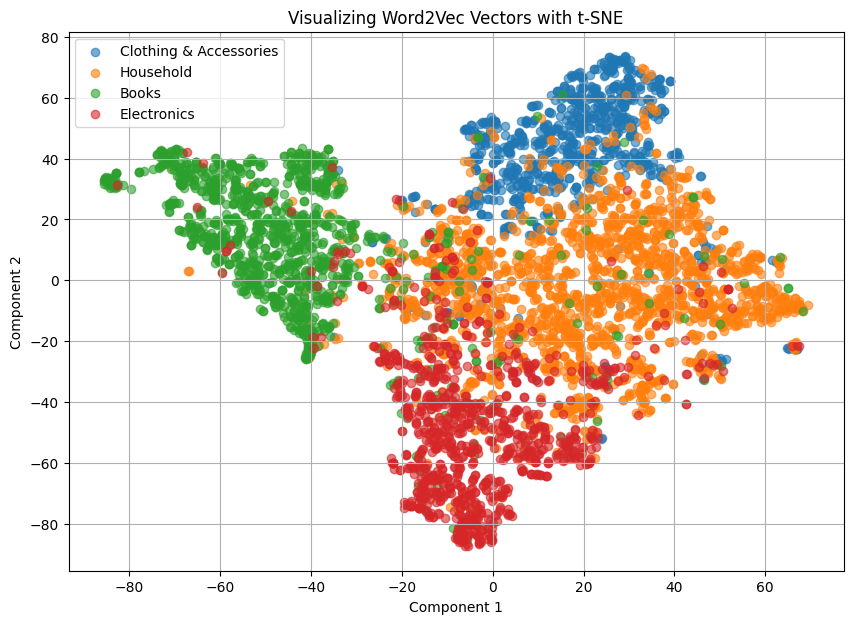

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_vis = X_w2v

# کاهش ابعاد با t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_vis)

# رسم
plt.figure(figsize=(10, 7))
for label in df["category"].unique():
    indices = df["category"] == label
    plt.scatter(X_2d[indices, 0], X_2d[indices, 1], label=label, alpha=0.6)

plt.legend()
plt.title("Visualizing Word2Vec Vectors with t-SNE")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()
